## Modelo de Detección de Deepfakes
Este es un ejemplo de entrenamiento para un modelo de Inteligencia Artificial que se enfoca en detectar imagenes falsas que hayan sido editadas o generadas por IA utilizando la tecnica conocida como Deep Learning.

El modelo esta realizado en un notebook de Python y pensado para poder guardarse en un directorio correspondiente una vez terminado su entrenamiento.

### Comprobamos el uso de la GPU
Para el entrenamiento de este modelo se recomienda utilizar una unidad de procesamiento grafico (GPU) para agilizar el proceso de entrenamiento. En caso de no poseer una, puede utilizar la potencia de su CPU para poder correr el entrenamiento. Sin embargo, le tomara mas tiempo hacerlo con ese enfoque.

In [1]:
# Testeamos que esta usando la GPU
import tensorflow as tf
gpu_available = tf.config.list_physical_devices('GPU')
if not gpu_available:
    print("GPU no disponible. Se usará la CPU.")
else:
    print("GPU disponible. Se usará la GPU:", gpu_available[0].name)
    print("---------------------------------")
    print("Información de la GPU:")
    # Revisamos información de la GPU
    !nvidia-smi

GPU disponible. Se usará la GPU: /physical_device:GPU:0
---------------------------------
Información de la GPU:
Sat Jun  8 01:40:57 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060 ...  WDDM  |   00000000:07:00.0  On |                  N/A |
|  0%   38C    P8             19W /  175W |    2062MiB /   8192MiB |     16%      Default |
|                          

### Generamos el dataset
Para poder trabajar con el conjunto de datos seleccionado, dividimos el contenido en 3 subcarpetas:
* Train
* Validation
* Test

De esta manera, podemos separar el contenido apropiadamente para trabajar el entrenamiento del modelo correctamente.

In [2]:
# Instalamos split-folders
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importamos librerias
import splitfolders
import os

# Definimos ruta de entrada y salida del dataset
input_folder = "../data/real_and_fake_face_detection/real_and_fake_face/"
output_folder = "../data/dataset/"

# Analizo si existe la carpeta dataset
if os.path.exists(output_folder):
    print("La carpeta dataset existe.")

    # Analizamos la distribución del directorio
    print(os.listdir(output_folder))
else:
    print("Creando carpeta dataset...")

    # Dividimos el dataset (80% entrenamiento, 10% validación, 10% test)
    splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1), group_prefix=None)

    for dir, dirname, files in os.walk(output_folder):
        print(f"Dir: {dir} | subdir: {dirname} | cantidad de imagenes: {len(files)}")

    print("Carpeta dataset creada con exito.")

La carpeta dataset existe.
['test', 'train', 'val']


### Visualizamos el contenido del Dataset

In [5]:
# Importamos librerias
import cv2
import matplotlib.pyplot as plt

# Definimos ruta de las imagenes
real_img_path = f"{output_folder}train/training_real/"
fake_img_path = f"{output_folder}train/training_fake/"

# Función para cargar imagen
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

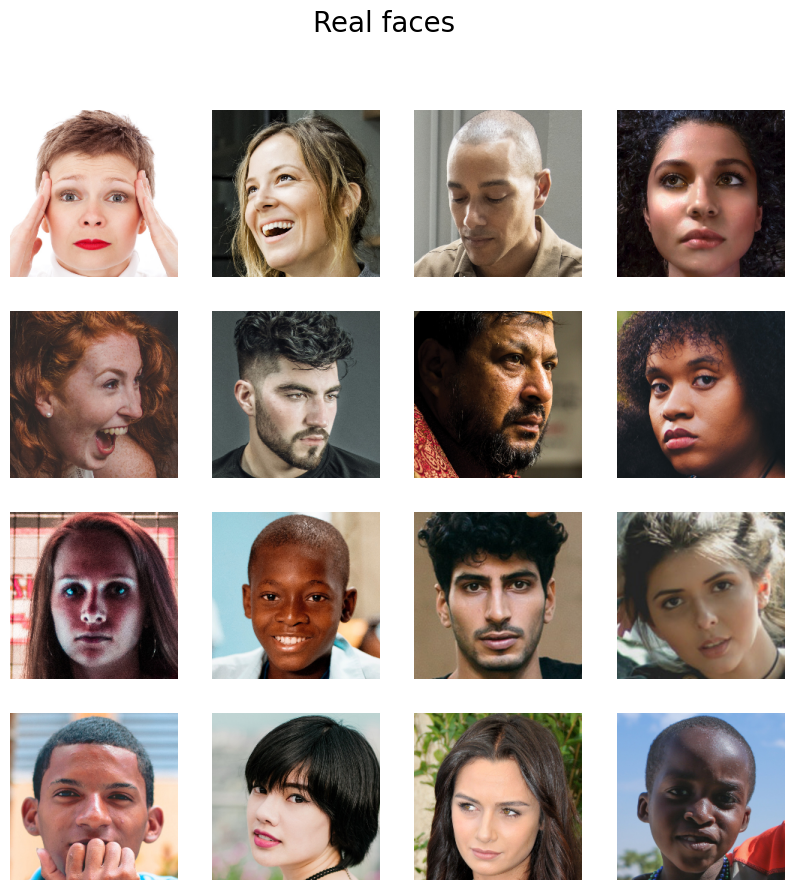

In [6]:
# Visualizamos las imagenes reales
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real_img_path + os.listdir(real_img_path)[i]))
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')

plt.show()

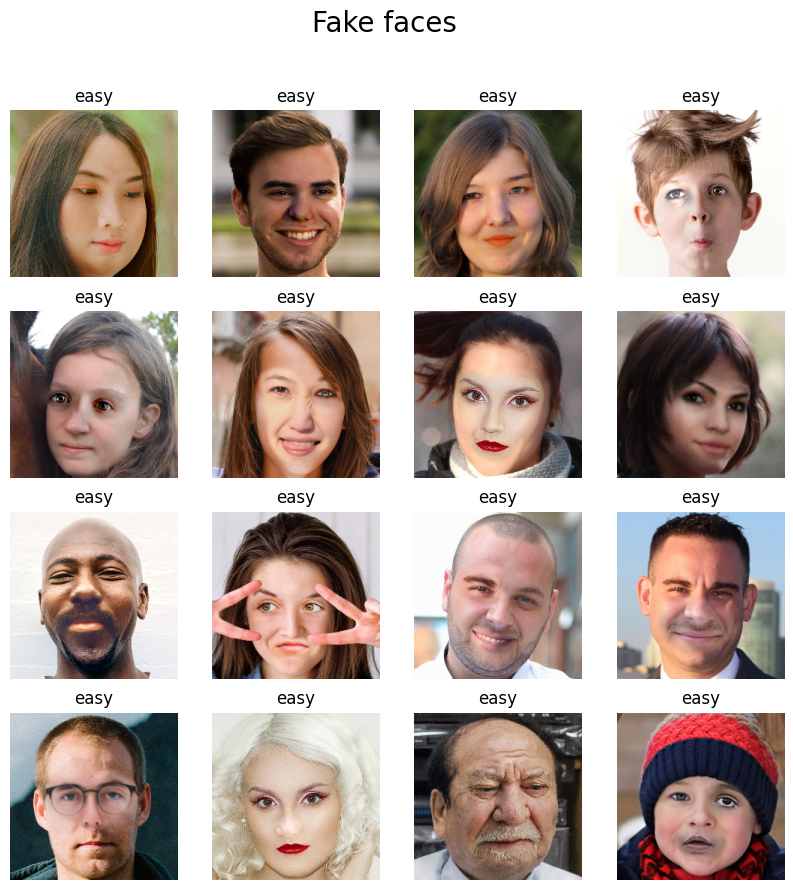

In [7]:
# Visualizamos las imagenes falsas
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake_img_path + os.listdir(fake_img_path)[i]))
    plt.suptitle("Fake faces",fontsize=20)
    plt.title(os.listdir(fake_img_path)[i][:4])
    plt.axis('off')

plt.show()

### Creamos la arquitectura de una Red Neuronal Convolucional (CNN)
Esta arquitectura se utiliza para encontrar patrones en nuestras imagenes. Los pasos a seguir son:
* Cargamos las imagenes con Tensorflow
* Preprocesamos las imagenes para escalarlas
* Construimos la CNN para clasificación
* Compilamos la CNN
* Entrenamos la CNN con los datos de entrenamiento

In [9]:
# Primero instanciamos el generador de dataset
# Este lo que hace es permitirnos preprocesar las imagenes (rescalarlas y aplicarles tecnicas de data augmentation)
import tensorflow as tf
tf.random.set_seed(42) # usamos este seed para que cada vez que ejecutemos la celda nos repetira los mismos valores, se usa mucho cuando queremos replicar experimentos

# Definimos las rutas de los directorios
train_dir = f"{output_folder}train/"
valid_dir = f"{output_folder}val/"
test_dir = f"{output_folder}test/"

# Generamos los datos de entrenamiento, validación y test
batch_size = 32
target_size = (96, 96)

# Configuracion de aumento de datos y normalizacion
datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                        vertical_flip=False,
                                                        rescale=1./255)
# Generacion de los datos de entrenamiento
train_batch = datagen.flow_from_directory(train_dir, 
                                          class_mode="binary", 
                                          target_size=target_size, 
                                          batch_size=batch_size, 
                                          subset="training")
# Generacion de los datos de validacion
valid_batch = datagen.flow_from_directory(valid_dir, 
                                          class_mode="binary", 
                                          target_size=target_size, 
                                          batch_size=batch_size)
# Generacion de los datos de test
test_batch = datagen.flow_from_directory(test_dir, 
                                         class_mode="binary", 
                                         target_size=target_size, 
                                         batch_size=batch_size)

Found 1632 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
Found 205 images belonging to 2 classes.


In [10]:
# Analizamos las clases y etiquetas
print("Clases del Dataset:", train_batch.class_indices)
print("Etiquetas del Dataset:", train_batch.labels)

Clases del Dataset: {'training_fake': 0, 'training_real': 1}
Etiquetas del Dataset: [0 0 0 ... 1 1 1]


### Utilizamos Transfer Learning

Utilizando la CNN pre entrenada MobileNetV2, creamos un modelo secuencial con distintas capas y lo utilizamos posteriormente para entrenarlo con nuestro train batch.

In [11]:
# Importamos librerias
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten

# Definimos la red MobileNetV2
mnet = MobileNetV2(input_shape=(96, 96, 3),
                          include_top=False,
                          weights='imagenet')

mnet.trainable = False

# Definimos la capa de GlobalAveragePooling2D
average_layer = GlobalAveragePooling2D()

# Definimos el modelo con las capas de MobileNetV2 y las capas densas
model = Sequential([
    Input(shape=(96, 96, 3)),
    mnet,
    average_layer,
    Flatten(),
    Dense(256, activation=tf.nn.relu),
    BatchNormalization(),
    Dropout(0.2),
    Dense(2, activation=tf.nn.softmax)
])

In [18]:
# Compilamos el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                        

In [19]:
# Definimos el learning rate scheduler
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [20]:
# Entrenamos el modelo
model.fit(train_batch, 
          epochs=50, 
          validation_data=valid_batch,
          callbacks=[lr_callbacks, tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/50
51/51 [==============================] - 20s 253ms/step - loss: 0.9953 - accuracy: 0.5625 - val_loss: 0.7198 - val_accuracy: 0.5686 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 10s 201ms/step - loss: 0.5944 - accuracy: 0.7077 - val_loss: 0.8169 - val_accuracy: 0.5637 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 10s 201ms/step - loss: 0.4994 - accuracy: 0.7512 - val_loss: 0.9712 - val_accuracy: 0.5392 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 10s 201ms/step - loss: 0.4012 - accuracy: 0.8235 - val_loss: 0.8117 - val_accuracy: 0.5441 - lr: 1.0000e-04
Epoch 5/50
51/51 [==============================] - 10s 200ms/step - loss: 0.3636 - accuracy: 0.8450 - val_loss: 0.8217 - val_accuracy: 0.5539 - lr: 1.0000e-04
Epoch 6/50
51/51 [==============================] - 10s 200ms/step - loss: 0.3448 - accuracy: 0.8474 - val_loss: 0.8091 - val_accuracy: 0.5735 - lr: 1.0000e-04
Epoch 7/50
51/51 [==============================] - 

In [21]:
# Evaluamos el modelo
test_results = model.evaluate(valid_batch)
print(f"Pérdida en el Test: {test_results[0]}")
print(f"Exactitud en el Test: {test_results[1]}")

7/7 [==============================] - 1s 144ms/step - loss: 0.7525 - accuracy: 0.5882
Pérdida en el Test: 0.7524950504302979
Exactitud en el Test: 0.5882353186607361


In [22]:
# Guardamos el modelo
model.save("../models/model_4.h5")